In [2]:
import sys
sys.path.append('../')

In [3]:
from src.models import *
import torch

In [ ]:
model = torch.load('/scratch/phys/sin/sethih1/models/planar_256/config2/seg_bs_32_lr_0.0001_loss_dice_loss', map_location=torch.device('cpu'), weights_only=False)
model.eval()  # Set the model to evaluation mode

NameError: name 'torch' is not defined

In [4]:
import py3Dmol
import numpy as np
from sklearn.cluster import KMeans
import spectral
import matplotlib.pyplot as plt

def visualize_3d_molecule(atom_pos, atomic_numbers):
    # Mapping atomic numbers to symbols
    atomic_number_to_symbol = {
        1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B',
        6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne'
    }
    symbols = [atomic_number_to_symbol.get(num, 'X') for num in atomic_numbers]

    # Create XYZ string
    xyz = f"{len(atom_pos)}\nMolecule\n"
    for symbol, pos in zip(symbols, atom_pos):
        xyz += f"{symbol} {pos[0]} {pos[1]} {pos[2]}\n"

    # Set up 3D viewer
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(xyz, 'xyz')
    viewer.setStyle({'stick': {}, 'sphere': {'radius': 0.5}})

    # Add labels for each atom
    for i, (symbol, pos) in enumerate(zip(symbols, atom_pos)):
        viewer.addLabel(symbol, {
            'position': {'x': float(pos[0]), 'y': float(pos[1]), 'z': float(pos[2])},
            'fontSize': 12,
            'fontColor': 'white',
            'backgroundColor': 'black',
            'alignment': 'center'
        })

    viewer.zoomTo()
    viewer.show()

def plot_channels(mol_image, title_name=None):
    fixed_atomic_numbers = ['background', 'H', 'C', 'N', 'O']
    fig, axes = plt.subplots(1, mol_image.shape[0], figsize=(15, 5))  # Adjust figsize as needed
    for i in range(mol_image.shape[0]):
        ax = axes[i]
        im = ax.imshow(mol_image[i], cmap='gray')
        ax.set_title(f"Channel {fixed_atomic_numbers[i]}")
        plt.colorbar(im, ax=ax, fraction=0.05)
    if title_name:
        fig.suptitle(title_name, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


def spectral_plot(spectrums):
    cube = spectrums
    rows, cols, bands = cube.shape

    # Example: KMeans to approximate endmembers
    flat = cube.reshape(-1, bands)
    kmeans = KMeans(n_clusters=6).fit(flat)
    labels = kmeans.labels_.reshape(rows, cols)

    # Visualize the cluster‐map
    plt.figure(figsize=(6,6))
    plt.imshow(labels, cmap='tab10')
    plt.title('Spectral-cluster map (6 clusters)')
    plt.axis('off')
    plt.show()

In [5]:
def add_disk(image, center, radius):
    """
    Draw a disk (circle) on a 2D image.
    
    Parameters:
      image: 2D numpy array where the disk will be added.
      center: Tuple (row, col) indicating the center of the disk.
      radius: Radius of the disk in pixels.
    """
    rows, cols = np.ogrid[:image.shape[0], :image.shape[1]]
    mask = (rows - center[0])**2 + (cols - center[1])**2 <= radius**2
    image[mask] = 1  # You can adjust the intensity if needed


def remove_disk(atom_pos, atomic_numbers):
    # Convert all positions to a numpy array
    ref = 1
    positions = np.array(atom_pos)
    zmax = np.max(positions[:, 2])
    positions = positions[positions[:, 2] > zmax - ref]

    filtered_atomic_numbers = [num for num, pos in zip(atomic_numbers, atom_pos) if pos[2] > (zmax - ref)]
    filtered_positions = [pos for pos in atom_pos if pos[2] > (zmax - ref)]

    '''
    print("Initial", filtered_positions)

    # Normalize the atom_pos by maximum distance
    pos = np.array(filtered_positions)
    cov = pos.T @ pos
    #filtered_positions /= np.max(cov)

    print("Normalized", filtered_positions)
    '''

    return filtered_positions, filtered_atomic_numbers


def molecule_circular_image(atom_pos, atomic_numbers, circle_radius=3):
    """
    Generate a multi-channel circular image representation of a molecule.
    
    Parameters:
      atom_pos: List or array of [x, y, z] coordinates for each atom.
      atomic_numbers: List of atomic numbers (integers) for each atom.
      circle_radius: Radius of the circle to draw for each atom in pixels.
      
    Returns:
      multi_channel_img: A numpy array of shape (num_elements, grid_size, grid_size).
    """
    # Define fixed channels for these atomic numbers
    fixed_atomic_numbers = [1, 6, 7, 8]  # H, C, N, O
    grid_size = 64  # Grid resolution
    
    filtered_positions, filtered_atomic_numbers = remove_disk(atom_pos, atomic_numbers)
    positions = np.array(filtered_positions)
    # Calculate the center of the molecule (using filtered positions)
    center_x = np.mean(positions[:, 0])
    center_y = np.mean(positions[:, 1])
    
    # Set fixed grid size of 18 Å centered on the molecule
    grid_physical_size = 18.0  # Å
    x_min = center_x - grid_physical_size / 2  # -9 Å
    x_max = center_x + grid_physical_size / 2  # +9 Å
    y_min = center_y - grid_physical_size / 2  # -9 Å
    y_max = center_y + grid_physical_size / 2  # +9 Å
    
    # Initialize multi-channel image array
    multi_channel_img = np.zeros((len(fixed_atomic_numbers), grid_size, grid_size))
    
    for ch, atomic_num in enumerate(fixed_atomic_numbers):
        # Extract positions for atoms that match the current atomic number
        pos = np.array([pos for num, pos in zip(filtered_atomic_numbers, filtered_positions) if num == atomic_num])
        if pos.size == 0:
            continue  # Skip if no atoms of this atomic number
        # Use only x and y coordinates
        pos = pos[:, :2]
    
        # Convert physical coordinates to grid indices
        x_idx = np.clip(((pos[:, 0] - x_min) / (x_max - x_min) * grid_size).astype(int), 0, grid_size - 1)
        y_idx = np.clip(((pos[:, 1] - y_min) / (y_max - y_min) * grid_size).astype(int), 0, grid_size - 1)
    
        # For each atom, add a circular disk to the image
        for x, y in zip(x_idx, y_idx):
            # Note: image indexing is (row, column) so we use (y, x)
            add_disk(multi_channel_img[ch], (y, x), circle_radius)
    
    return multi_channel_img

In [6]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

shape = 256
average_image = np.zeros((shape,shape,1))
channels_glob = np.zeros((400, shape, shape))
def normalize(spectrums):
    mean = np.mean(spectrums, axis = (0,1))
    std = np.std(spectrums, axis=(0,1))
    std[std==0] = 1
    spectrums = (spectrums - mean)/std
    return spectrums

def minmax(spectrums):
    min = np.min(spectrums, axis = (0,1))
    max = np.max(spectrums, axis = (0,1))
    diff = max - min 
    diff[diff==0] = 1
    spectrums = (spectrums - min)/diff

    return spectrums

def uniform_channels(spectrums, frequencies):
    """
    Create uniform channels from the spectrums.
    Returns an array of shape (64, 64, 40) by averaging spectrums in frequency bins.
    """
    # Initialize output array: 40 channels, each 64x64
    num_channels = 400
    shape = spectrums.shape[0]
    channels = np.zeros((shape, shape, num_channels))
    max_freq = 4000
    
    # Define step size based on the maximum frequency and number of channels.
    step = max_freq // num_channels

    spectrums = minmax(spectrums)

    count = 0 
    # For each frequency bin, compute the average spectrum.
    for i in range(1, max_freq, step):
        
        # Find indices for frequencies in this bin. Adjust band width as needed.
        indices = (frequencies > i) & (frequencies < i + step)
        if indices.sum() != 0:
            print(i, count)
        selected_spectrums = spectrums[:, :, indices]
        # If no data or the data is all zeros, continue.
        if selected_spectrums.size == 0 or np.all(selected_spectrums == 0):
            count += 1
            continue
        # Compute the mean across the frequency axis
        channels[:, :, count] = np.mean(selected_spectrums, axis=2)
        count += 1

    return channels



def get_element_color(atomic_number):
    """Returns a color based on atomic number."""
    # Map atomic numbers to colors (same as original but keyed by number)
    color_map = {
        1: 'lightgray',  # Hydrogen
        2: 'cyan',       # Helium
        3: 'purple',     # Lithium
        4: 'brown',      # Beryllium
        5: 'pink',       # Boron
        6: 'black',      # Carbon
        7: 'blue',       # Nitrogen
        8: 'red',        # Oxygen
        9: 'green',      # Fluorine
        10: 'orange'     # Neon
    }
    return color_map.get(atomic_number, 'gray')  # Default color for unknown elements

In [7]:
def overlay_molecule_on_image(atom_pos, atomic_numbers, image, axes, grid_size=18.0, bond_threshold=1.6):
    """
    Overlay molecule visualization on a given image (e.g., average channel or individual channel).
    
    Parameters:
    - atom_pos: Array of [x, y, z] coordinates for each atom (in angstroms).
    - atomic_numbers: List of atomic numbers.
    - image: 2D numpy array (64x64) to overlay the molecule on.
    - axes: Matplotlib axes object to plot on.
    - grid_size: Physical size of the grid in angstroms (default 16 Å).
    - bond_threshold: Maximum distance for drawing bonds (in angstroms).
    """
    # Display the image as the background
    axes.imshow(image, cmap='gray', extent=(-grid_size/2, grid_size/2, -grid_size/2, grid_size/2), origin='lower')

    # Center the molecule
    positions = np.array(atom_pos)
    center_x = np.mean(positions[:, 0])
    center_y = np.mean(positions[:, 1])
    centered_pos = positions - [center_x, center_y, 0]  # Center in x-y plane

    # Draw bonds
    num_atoms = len(centered_pos)
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance = np.linalg.norm(centered_pos[i] - centered_pos[j])
            if distance < bond_threshold:
                axes.plot([centered_pos[i, 0], centered_pos[j, 0]],
                          [centered_pos[i, 1], centered_pos[j, 1]],
                          'gray', linewidth=1.5, zorder=1)

    # Draw atoms
    for i, (x, y, _) in enumerate(centered_pos):
        color = get_element_color(atomic_numbers[i])
        symbol = {1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B',
                  6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne'}.get(atomic_numbers[i], 'X')
        axes.scatter(x, y, s=200, c=color, edgecolors='black', zorder=2)
        axes.text(x, y, symbol, fontsize=10, color='white',
                  ha='center', va='center', fontweight='bold', zorder=3)

    # Set axis properties
    axes.set_xlim(-grid_size/2, grid_size/2)
    axes.set_ylim(-grid_size/2, grid_size/2)
    axes.set_aspect('equal')
    axes.set_axis_off()


In [8]:


def molecule_visualization_image(atom_pos, atomic_numbers, bond_threshold=1.6, axes=None):
    """
    Creates a scatter plot visualization of a molecule with element-based colors and bonds.
    
    Parameters:
    - atom_pos: List or array of [x, y, z] coordinates for each atom.
    - atomic_numbers: List of atomic numbers (integers) for each atom.
    - bond_threshold: Maximum distance (in units of atom_pos) for drawing bonds.
    - axes: Matplotlib axes object to plot on. If None, a new figure and axes are created.
    """
    # Define mapping from atomic numbers to element symbols
    atomic_number_to_symbol = {
        1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B',
        6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne'
        # Add more elements as needed
    }

    # Convert atomic numbers to symbols, using 'X' for unknown elements
    element_symbols = [atomic_number_to_symbol.get(num, 'X') for num in atomic_numbers]

    # Set up the axes
    if axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))
        created_figure = True
    else:
        created_figure = False

    # Draw bonds based on distance threshold
    num_atoms = len(atom_pos)
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance = np.linalg.norm(atom_pos[i] - atom_pos[j])
            if distance < bond_threshold:
                axes.plot([atom_pos[i, 0], atom_pos[j, 0]],
                          [atom_pos[i, 1], atom_pos[j, 1]],
                          'gray', linewidth=1.5, zorder=1)

    # Draw atoms with different colors
    for i, (x, y, _) in enumerate(atom_pos):
        atomic_number = atomic_numbers[i]
        color = get_element_color(atomic_number)
        symbol = element_symbols[i]
        axes.scatter(x, y, s=200, c=color, edgecolors='black', zorder=2)
        axes.text(x, y, symbol, fontsize=10, color='white',
                  ha='center', va='center', fontweight='bold')

    # Create legend manually
    unique_atomic_numbers = set(atomic_numbers)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                          markerfacecolor=get_element_color(num),
                          markeredgecolor='black',
                          label=atomic_number_to_symbol.get(num, 'X'))
               for num in unique_atomic_numbers]
    axes.legend(handles=handles, title="Elements", loc="upper right")

    # Set title and axis properties
    axes.set_title("Molecule Visualization")
    axes.set_aspect('equal')
    axes.set_axis_off()

    # Finalize layout and display if a new figure was created
    if created_figure:
        fig.tight_layout()
        plt.show()

        



def main(npz_file, frequency_range=(0, 4000)):
    global average_image
    # Read the npz file
    print(f"Reading file: {npz_file}")
    with np.load(npz_file) as data:
        atom_pos = data['atom_pos']
        atomic_numbers = data['atomic_numbers']
        frequencies = data['frequencies']
        spectrums = data['spectrums']

    # Create uniform channels
    channels = uniform_channels(spectrums, frequencies)

    channels_glob = channels
    channels = minmax(channels)


    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    # Visualize the molecule
    molecule_visualization_image(np.array(atom_pos), np.array(atomic_numbers), axes=axs[0])
    axs[0].set_title("Original Molecule")
    axs[0].set_frame_on(True)
    #channels[channels > 0.1] = 1

    # Visualizing filtered molecule
    filted_atom_pos, filtered_atomic_numbers = remove_disk(atom_pos, atomic_numbers)
    molecule_visualization_image(np.array(filted_atom_pos), np.array(filtered_atomic_numbers), axes=axs[1])
    axs[1].set_title("Filtered Molecule")
    axs[1].set_frame_on(True)
    line_x = 0.5  # Middle of the figure (since we have two subplots)
    fig.add_artist(plt.Line2D([line_x, line_x], [0, 1], color='black', linewidth=2, transform=fig.transFigure))
    plt.tight_layout()
    plt.show()

    mol_image = molecule_circular_image(np.array(atom_pos), np.array(atomic_numbers))


    

    # Plot only non-empty channels in one figure using subplots.
    H, W, num_channels = channels.shape
    non_empty_channels = [i for i in range(num_channels) if np.any(channels[:, :, i] != 0)]
    num_non_empty_channels = len(non_empty_channels)


    # Compute and plot the average image across all non-empty channels.
    non_empty_channel_images = channels[:, :, non_empty_channels]
    average_image[:, :, 0] = np.mean(non_empty_channel_images, axis=2)
    #average_image = np.sum(non_empty_channel_images, axis=2)
    average_image = average_image.reshape(average_image.shape[0], average_image.shape[1], -1)
    #average_image = minmax(average_image)
    average_image = np.log1p(average_image)
    plt.figure(figsize=(5, 5))
    plt.imshow(average_image, cmap='gray', origin='lower')
    plt.colorbar()
    plt.title("Average of Non-Empty Channels")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    visualize_3d_molecule(atom_pos, atomic_numbers)
    
    n_cols = 5
    n_rows = int(np.ceil(num_non_empty_channels / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    axes = axes.flatten()


    for i, idx in enumerate(non_empty_channels):
        im = axes[i].imshow(channels[:, :, idx], cmap='gray')
        axes[i].set_title(f"Channel {idx}, f= {idx*5}-{idx*5+5}")
        plt.colorbar(im,ax = axes[i])
        axes[i].axis('off')
    
    # Hide any extra subplots if the grid is larger than the number of non-empty channels.
    for j in range(num_non_empty_channels, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

    return channels_glob, mol_image
   


In [9]:
def main(npz_file, frequency_range=(0, 4000)):
    global average_image
    # Read the npz file
    print(f"Reading file: {npz_file}")
    with np.load(npz_file) as data:
        atom_pos = data['atom_pos']
        atomic_numbers = data['atomic_numbers']
        frequencies = data['frequencies']
        spectrums = data['spectrums']


    print(atom_pos)
    print(frequencies)
    # Create uniform channels
    channels = uniform_channels(spectrums, frequencies)
    channels_glob = channels
    channels = minmax(channels)

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    # Visualize the molecule
    molecule_visualization_image(np.array(atom_pos), np.array(atomic_numbers), axes=axs[0])
    axs[0].set_title("Original Molecule")
    axs[0].set_frame_on(True)
    #channels[channels > 0.1] = 1

    # Visualizing filtered molecule
    filted_atom_pos, filtered_atomic_numbers = remove_disk(atom_pos, atomic_numbers)
    molecule_visualization_image(np.array(filted_atom_pos), np.array(filtered_atomic_numbers), axes=axs[1])
    axs[1].set_title("Filtered Molecule")
    axs[1].set_frame_on(True)
    line_x = 0.5  # Middle of the figure (since we have two subplots)
    fig.add_artist(plt.Line2D([line_x, line_x], [0, 1], color='black', linewidth=2, transform=fig.transFigure))
    plt.tight_layout()
    plt.show()

    # Compute average image
    non_empty_channels = [i for i in range(channels.shape[2]) if np.any(channels[:, :, i] != 0)]
    non_empty_channel_images = channels[:, :, non_empty_channels]
    average_image[:, :, 0] = np.mean(non_empty_channel_images, axis=2)
    average_image_log = np.log1p(average_image[:, :, 0])  # For visualization

    #print(channels.shape)
    #spectral_plot(channels)

    # Overlay on average channel
    plt.figure(figsize=(4, 4))
    ax = plt.gca()

    filtered_atom_pos, filtered_atomic_numbers = remove_disk(atom_pos, atomic_numbers)
    overlay_molecule_on_image(filtered_atom_pos, filtered_atomic_numbers, average_image_log, ax, grid_size=18.0)
    basename = os.path.splitext(os.path.basename(npz_file))[0]
    plt.title(f"Molecule {basename} Overlaid on Average Channel")
    plt.tight_layout()
    plt.show()


    

    # Overlay on each non-empty channel
    n_cols = 5
    n_rows = int(np.ceil(len(non_empty_channels) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    axes = axes.flatten()

    for i, idx in enumerate(non_empty_channels):
        overlay_molecule_on_image(filtered_atom_pos, filtered_atomic_numbers, channels[:, :, idx], axes[i], grid_size=18.0)
        indices = (frequencies > (idx * 10 + 1)) & (frequencies < ((idx + 1) * 10 + 1))
        t = ', '.join([str(np.round(frequencies[j],2)) for j in range(len(frequencies)) if indices[j]]) + ' cmˆ-1'
        #axes[i].set_title(f"Channel {idx}, f={frequencies[indices]}")
        axes[i].set_title(f"f={t}")

    # Hide extra subplots
    for j in range(len(non_empty_channels), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    return channels_glob, molecule_circular_image(np.array(atom_pos), np.array(atomic_numbers))

Reading file: /scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/170404.npz
[[ 2.47040435e-01 -1.95071107e+00 -2.13403076e-02]
 [ 2.87414188e+00  5.22568811e-01 -1.41083218e-02]
 [-1.64517751e+00  1.79056089e+00  2.89945243e-02]
 [ 1.49087545e+00 -1.58835219e+00 -2.55815321e-02]
 [-1.90030571e+00 -6.37812750e-01  6.31790260e-03]
 [-2.45870393e+00  6.49674448e-01  2.31064635e-02]
 [ 1.69189917e+00 -1.17921691e-01 -1.23553730e-02]
 [-5.13677567e-01 -7.45624763e-01 -3.95985954e-03]
 [ 3.13042006e-01  4.02215836e-01  1.86719550e-03]
 [-2.46178222e-01  1.67705940e+00  1.82786606e-02]
 [ 3.81399117e+00 -3.46175548e-02 -2.62520657e-02]
 [ 3.79645443e-01  2.57311741e+00  2.28741031e-02]
 [-2.52333187e+00 -1.53384195e+00  1.07712786e-03]
 [ 2.30327914e+00 -2.32078914e+00 -3.84000749e-02]
 [-2.10545460e+00  2.78092090e+00  4.14839277e-02]
 [-3.54499853e+00  7.65121039e-01  3.07318639e-02]
 [ 2.93979640e+00  1.61304849e+00 -3.80882098e-03]]
[ 104.696004  189.454662  224.3

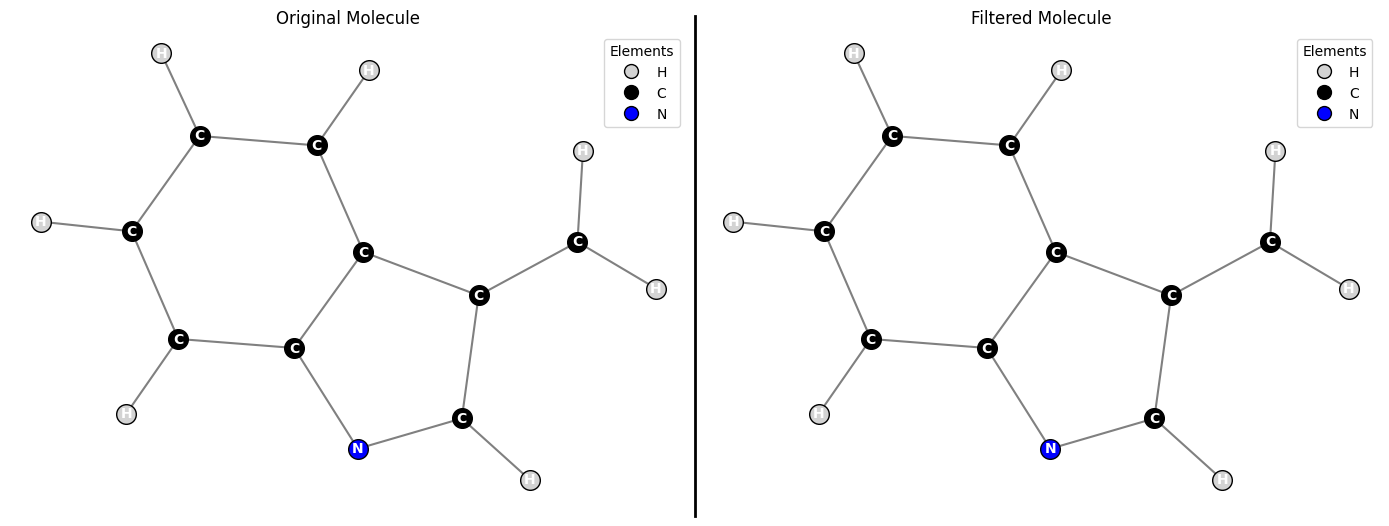

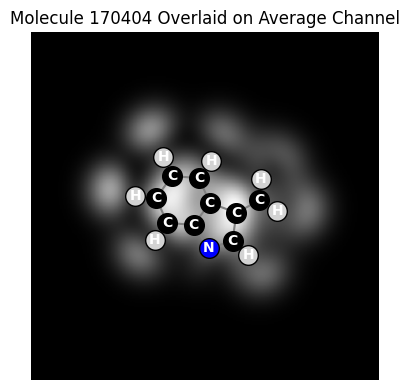

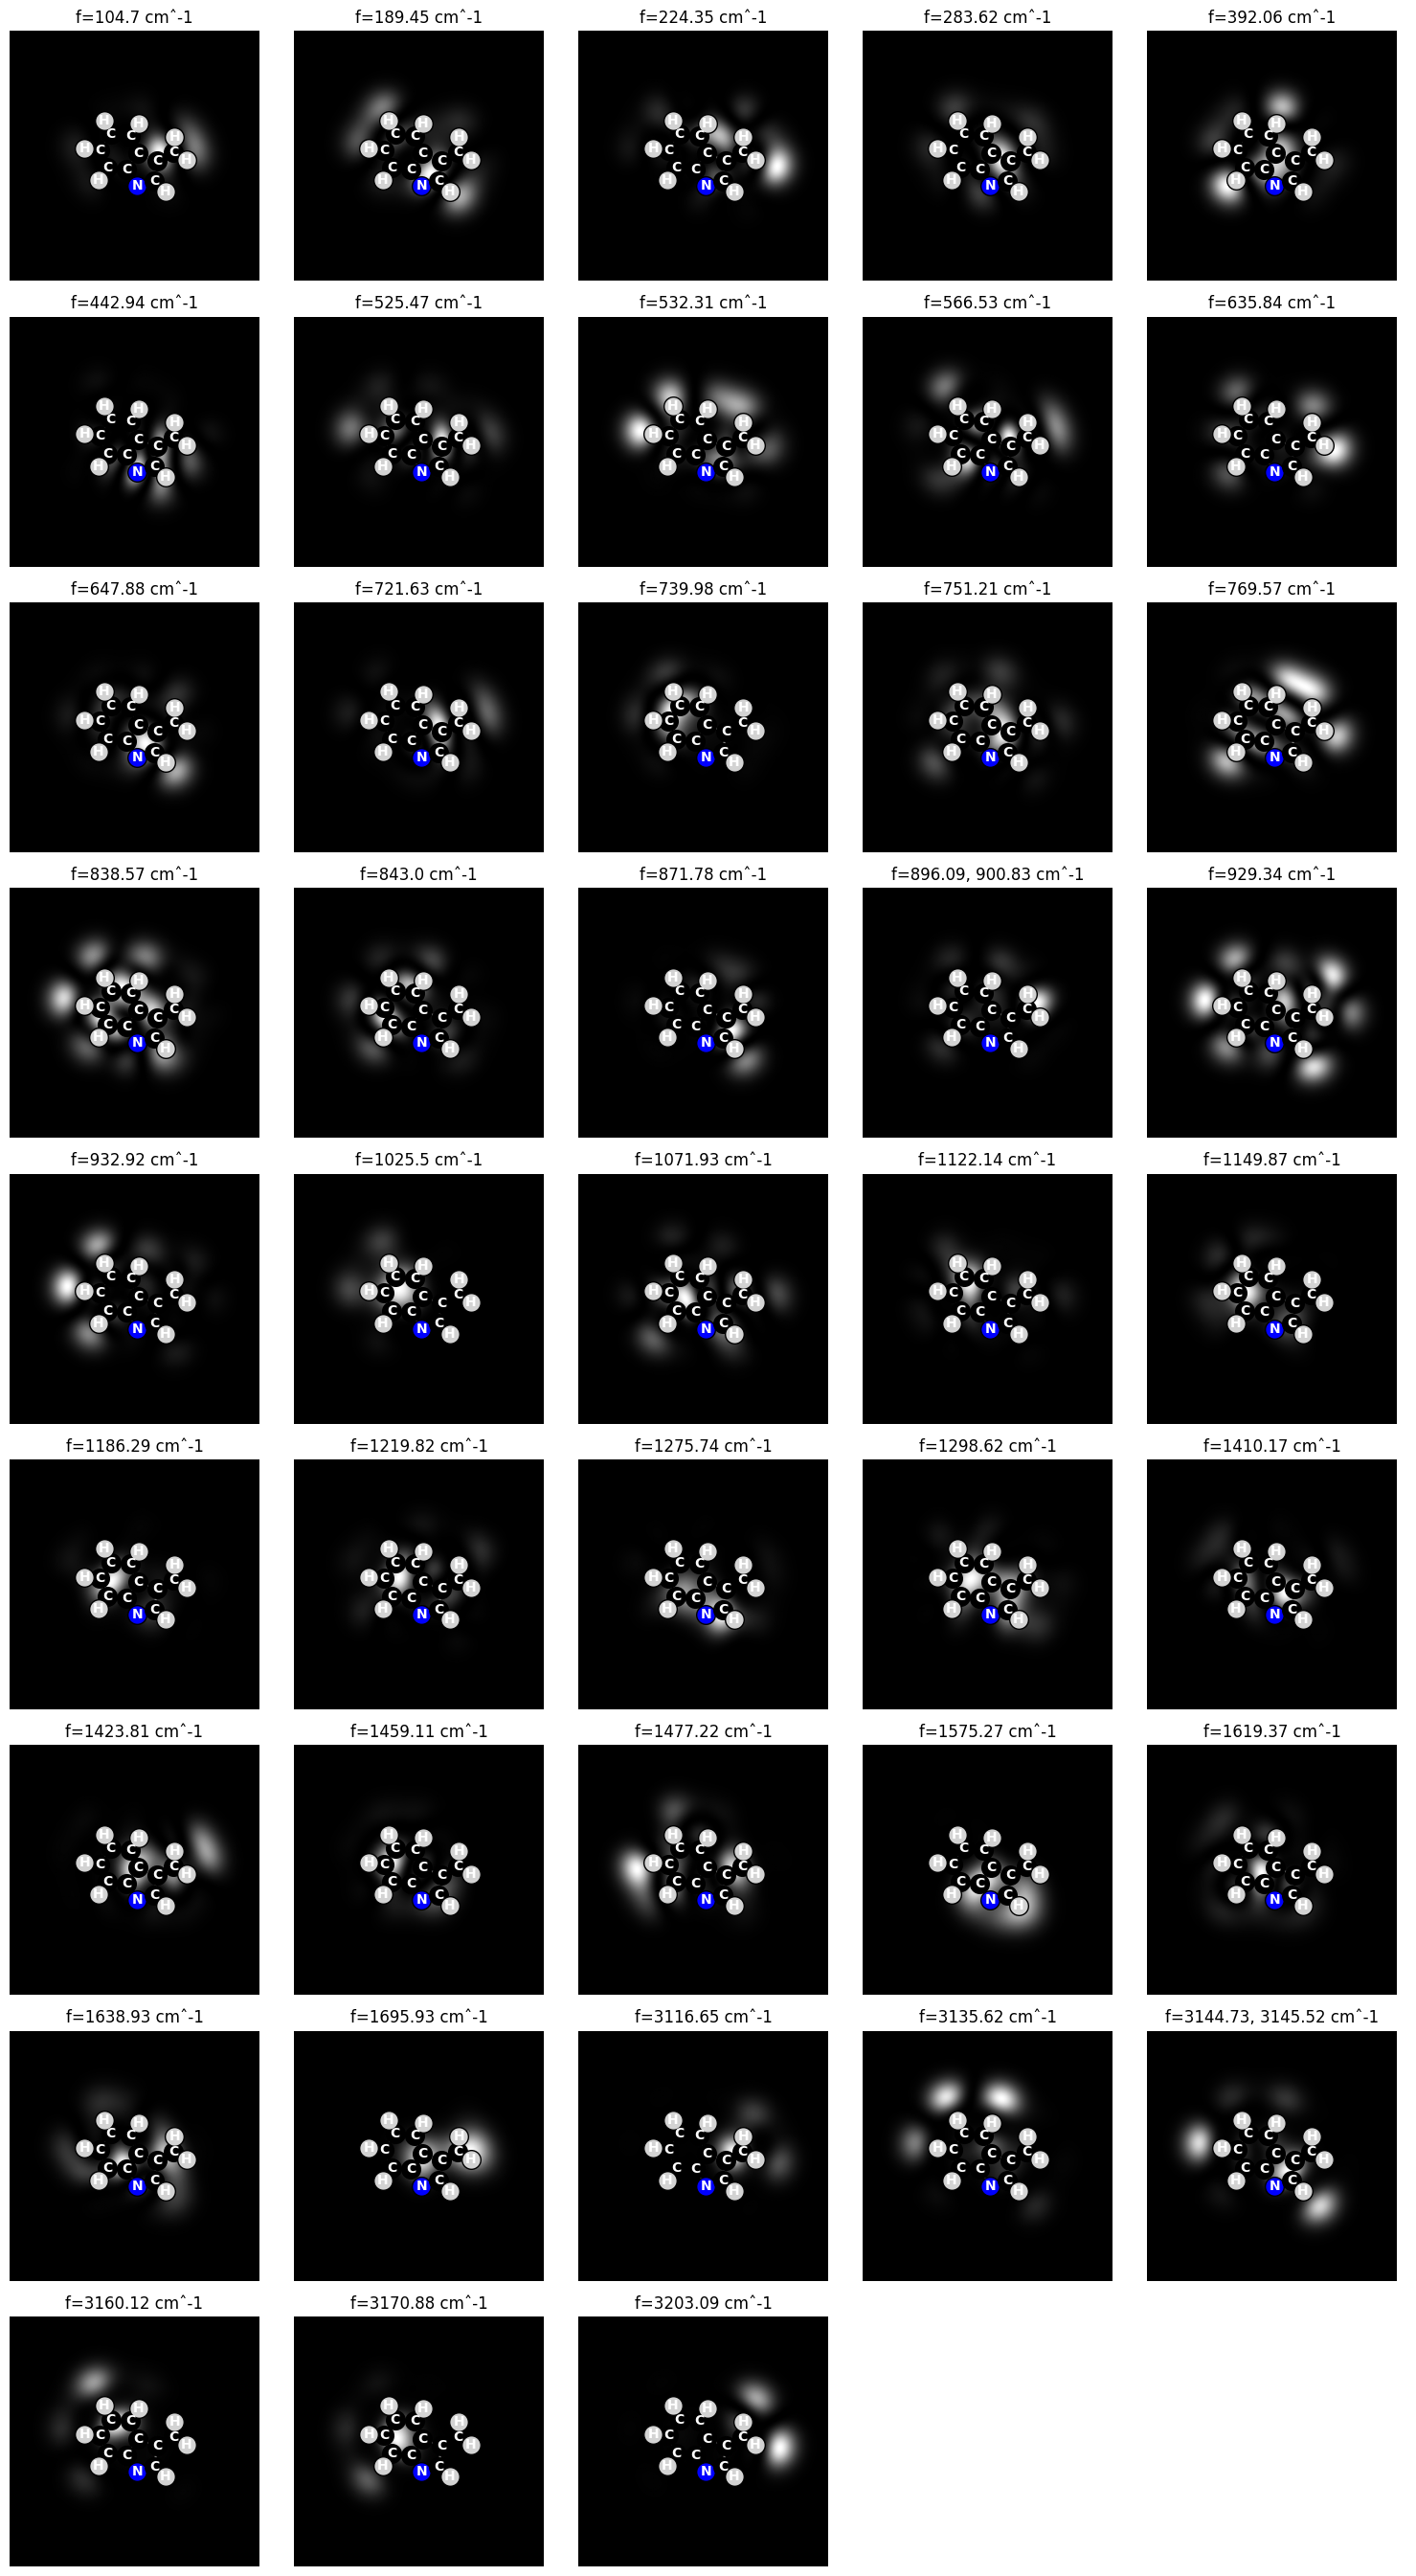

In [10]:
npz_file = '/scratch/phys/sin/sethih1/data_files/first_group_images_256/10038.npz'
#npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_images_new/137676.npz'
#npz_file = '/scratch/phys/sin/sethih1/data_files/third_group_images/100010.npz'
#npz_file = '/scratch/phys/sin/sethih1/data_files/second_group_images_256/7847.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/first_group_images_256/68037.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/plane_second_group_images/123178.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/plane_first_group_images/7492.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images/123178.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images/11473.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/7492.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/old/planar_molecules_256_old/7847.npz'
#npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/123178.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/7847.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/170404.npz'
channels_glob_n, mol_image = main(npz_file)

Reading file: /scratch/phys/sin/sethih1/data_files/old/planar_molecules_256_old/7847.npz
[[-1.717176 -0.119346  0.004378]
 [ 0.643587 -0.42751   0.060891]
 [-0.603     0.357211 -0.051337]
 [ 1.844809  0.162519 -0.009325]
 [ 0.526652 -1.506105  0.204463]
 [-0.444026  1.45907  -0.197857]
 [ 2.775943 -0.40247   0.074803]
 [ 1.93073   1.244894 -0.153602]]
[  89.2573002  278.461752   557.236952   579.250312   898.591861
  940.295648   976.547158  1006.3883    1145.60284   1267.3951
 1365.88095   1426.03065   1673.65688   1812.90141   2818.75361
 3105.04194   3141.44576   3198.14456  ]
81 8
271 27
551 55
571 57
891 89
931 93
971 97
1001 100
1141 114
1261 126
1361 136
1421 142
1671 167
1811 181
2811 281
3101 310
3141 314
3191 319


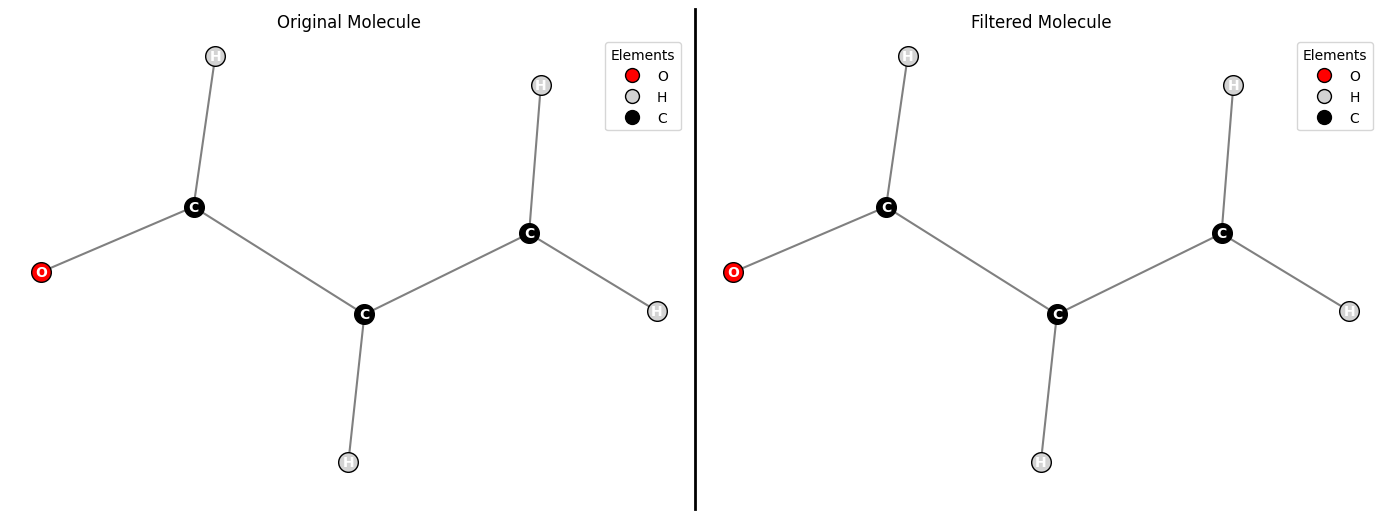

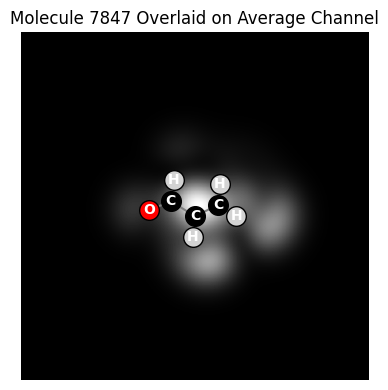

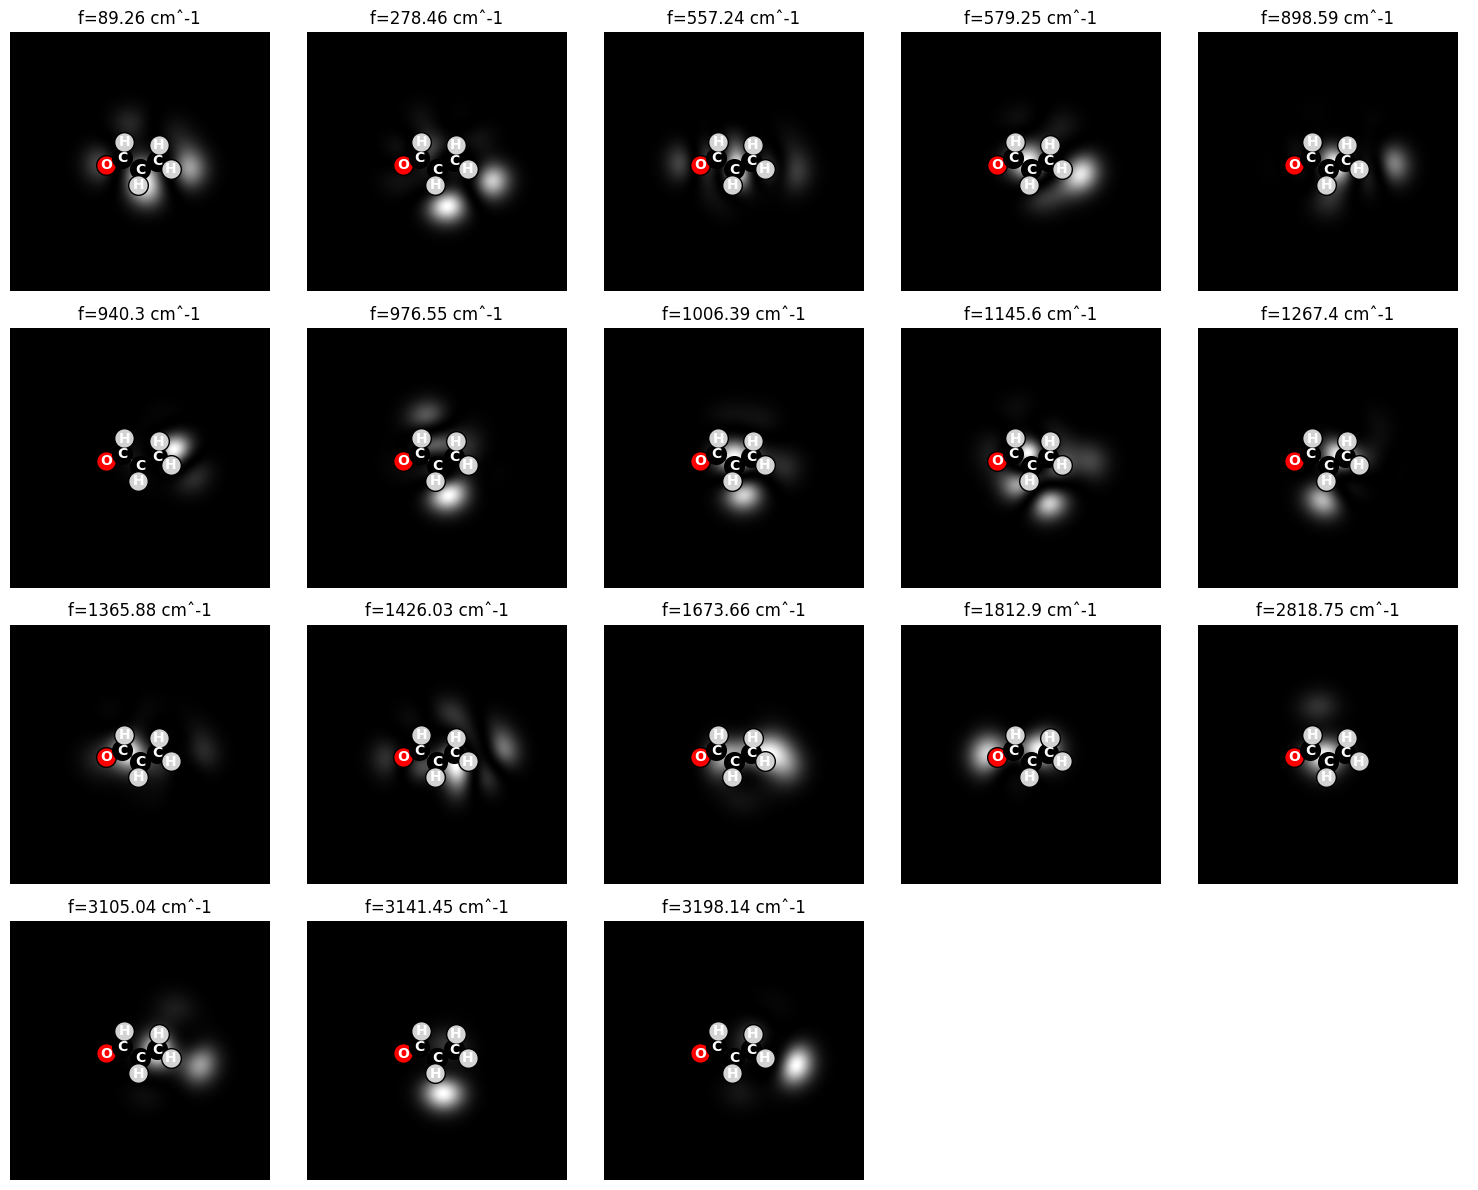

In [14]:
npz_file = '/scratch/phys/sin/sethih1/data_files/old/planar_molecules_256_old/7847.npz'
channels_glob_n, mol_image = main(npz_file)

In [9]:
channels_glob = torch.tensor(channels_glob_n).permute(2,0,1).unsqueeze(0).float()
'''for i in range(0, channels_glob.shape[1]):
    c = channels_glob[:, i, :, :]
    if torch.max(c) - torch.min(c) != 0:
        channels_glob[:, i, :, :] = (c- torch.min(c)) / (torch.max(c) - torch.min(c))
print(channels_glob.shape)
'''

cmin = channels_glob.amin(dim=(2,3), keepdim=True)
cmax = channels_glob.amax(dim=(2,3), keepdim=True)

denom = cmax = cmin 
mask = denom !=0 

channels_glob = torch.where(mask, (channels_glob - cmin)/denom, channels_glob)
print(channels_glob.shape)

NameError: name 'torch' is not defined

In [ ]:
out = model(channels_glob)

KeyboardInterrupt: 

In [3]:
from src.datasets.ters_image_to_image_sh import Ters_dataset_filtered_skip

data_path = '/scratch/phys/sin/sethih1/data_files/planar_molecules_256/'
ters_set = Ters_dataset_filtered_skip(
        filename=data_path,
        frequency_range=[0, 4000],  # adjust as needed
        std_deviation_multiplier=2,
        t_image=None,
        t_freq=None
    )

In [16]:
dataloader = torch.utils.data.DataLoader(ters_set, batch_size=8, shuffle=False)
input, selected_frequencies, target_image = dataloader.__iter__().__next__()
out = model(input) # .expand(1, -1, -1, -1))

In [17]:
out.shape

torch.Size([8, 1, 256, 256])

(8, 1, 256, 256)


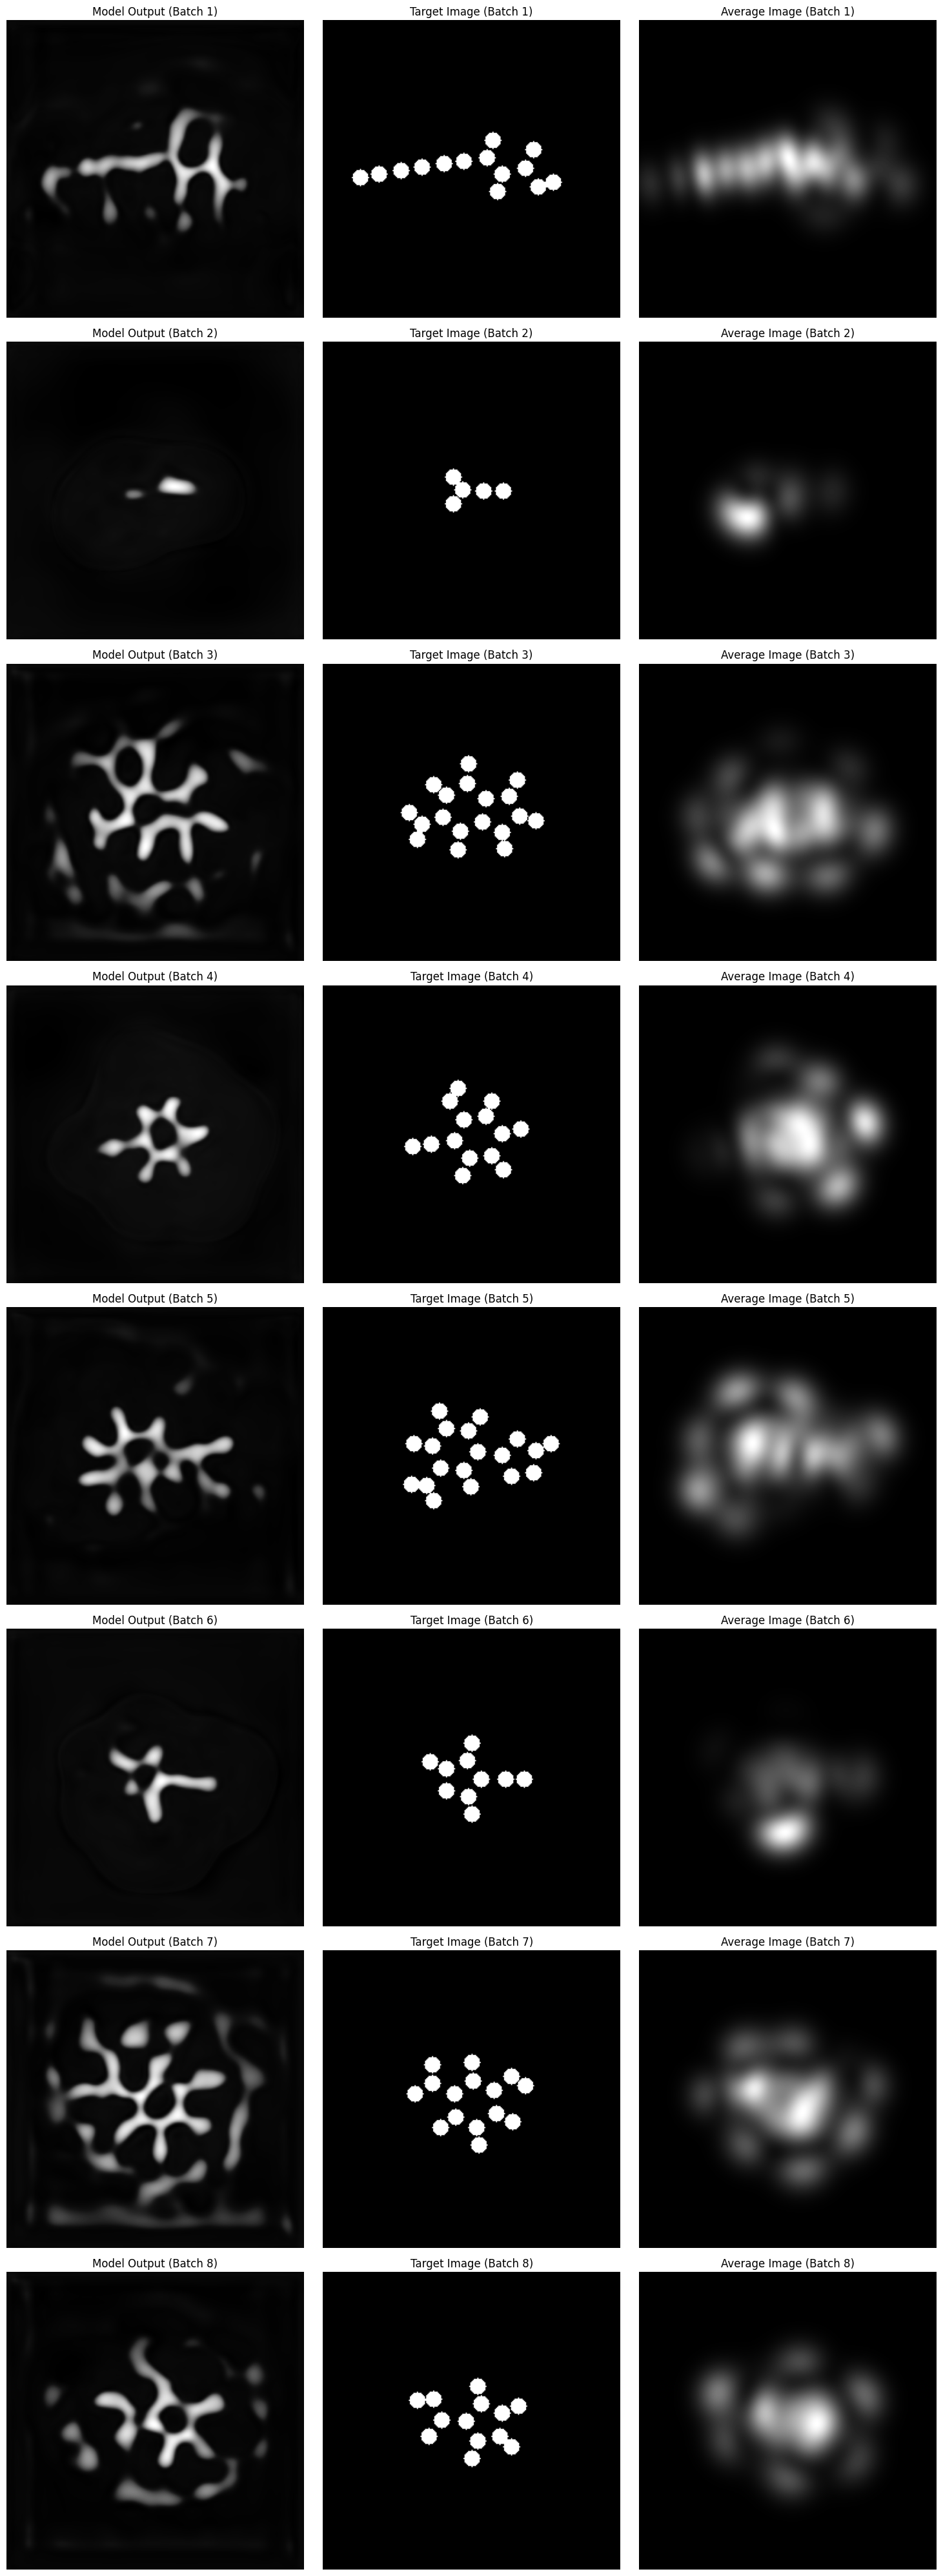

In [18]:
# Determine the number of rows and columns for the grid
batch_size = out.shape[0]
rows = batch_size
cols = 3  # One column for model output, one for target image, and one for average image
avg_img = torch.mean(input, dim=1, keepdim=True).numpy()

print(avg_img.shape)

# Create a figure for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Ensure axes is iterable for a single batch
if batch_size == 1:
    axes = [axes]

for i in range(batch_size):
    # Plot the output tensor
    axes[i][0].imshow(out.detach().numpy()[i, 0], cmap='gray')
    axes[i][0].set_title(f"Model Output (Batch {i+1})")
    axes[i][0].axis('off')

    # Plot the target image
    axes[i][1].imshow(target_image.numpy()[i, 0], cmap='gray')
    axes[i][1].set_title(f"Target Image (Batch {i+1})")
    axes[i][1].axis('off')

    # Plot the average image
    axes[i][2].imshow(avg_img[i, 0], cmap='gray')
    axes[i][2].set_title(f"Average Image (Batch {i+1})")
    axes[i][2].axis('off')

plt.tight_layout()
plt.show()

TypeError: Invalid shape (1, 256, 256) for image data

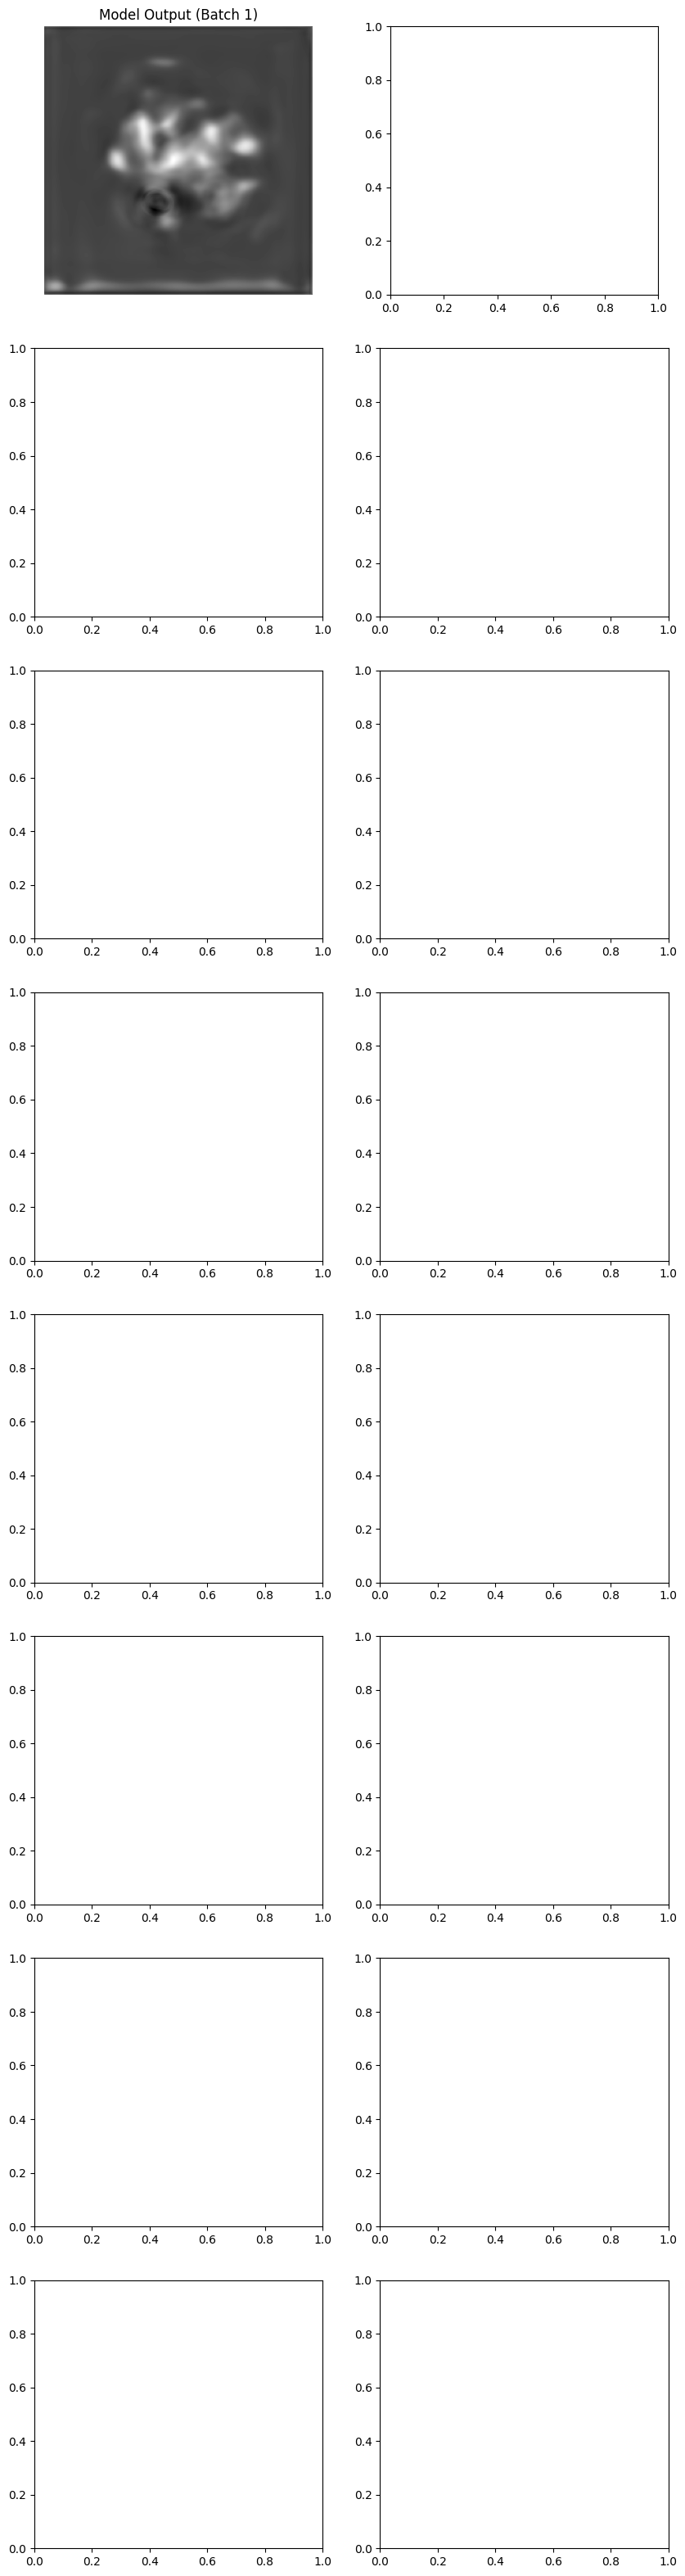

In [85]:
batch_size = out.shape[0]  # Get the batch size from the output tensor
fig, axes = plt.subplots(batch_size, 2, figsize=(10, 5 * batch_size))

if batch_size == 1:
    axes = [axes]  # Ensure axes is iterable for a single batch

for i in range(batch_size):
    # Plot the output tensor
    axes[i][0].imshow(out.detach().numpy()[i, 0], cmap='gray')
    axes[i][0].set_title(f"Model Output (Batch {i+1})")
    axes[i][0].axis('off')

    # Plot the target image
    axes[i][1].imshow(target_image.numpy()[i], cmap='gray')
    axes[i][1].set_title(f"Target Image (Batch {i+1})")
    axes[i][1].axis('off')

plt.tight_layout()
plt.show()

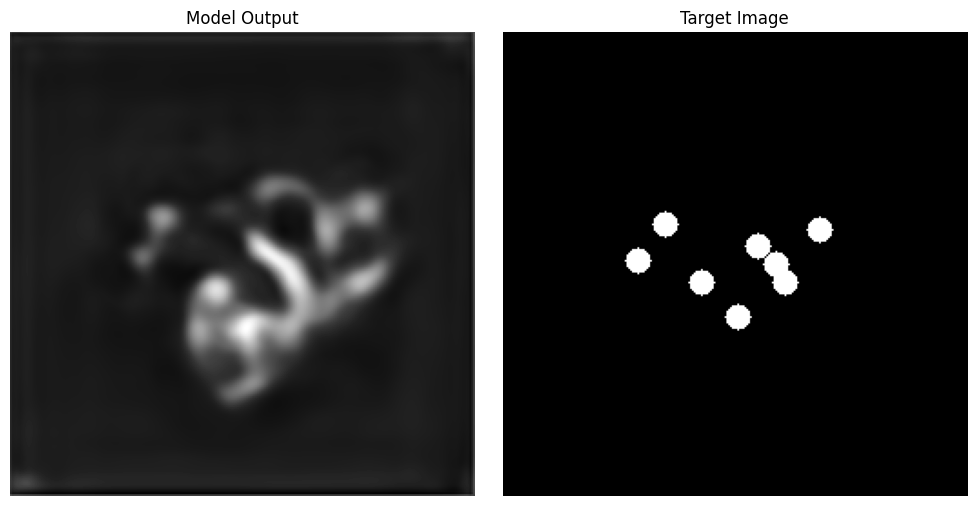

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the output tensor
axes[0].imshow(out.detach().numpy()[0, 0], cmap='gray')
axes[0].set_title("Model Output")
axes[0].axis('off')

# Plot the target image
axes[1].imshow(target_image.numpy()[0], cmap='gray')
axes[1].set_title("Target Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Define custom colors for each label
colors = ["black", "red", "green", "blue"]  # 0 → black, 1 → red, 2 → green, 3 → blue
custom_cmap = ListedColormap(colors)

mol_image_new = np.zeros((5, 64, 64))
mol_image_new[1:, :, :] = mol_image
t = np.argmax(mol_image_new, axis=0)

Text(0.5, 1.0, 'Segmentation Prediction')

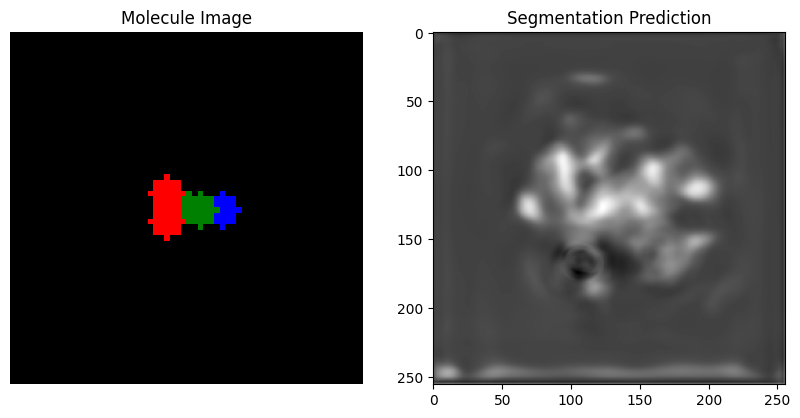

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(t, cmap=custom_cmap, interpolation='nearest')
axes[0].set_title("Molecule Image")
axes[0].axis('off')
axes[1].imshow(out[0][0].detach().numpy(), cmap='gray')
axes[1].set_title("Segmentation Prediction")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


mol_image_new = np.zeros((5, 64, 64))
mol_image_new[1:, :, :] = mol_image
t = np.argmax(mol_image_new, axis=0)
# Define custom colors for each label
colors = ["black", "red", "green", "blue"]  # 0 → black, 1 → red, 2 → green, 3 → blue
custom_cmap = ListedColormap(colors)

# Plot with fixed colors
plt.imshow(t, cmap=custom_cmap, interpolation='nearest')

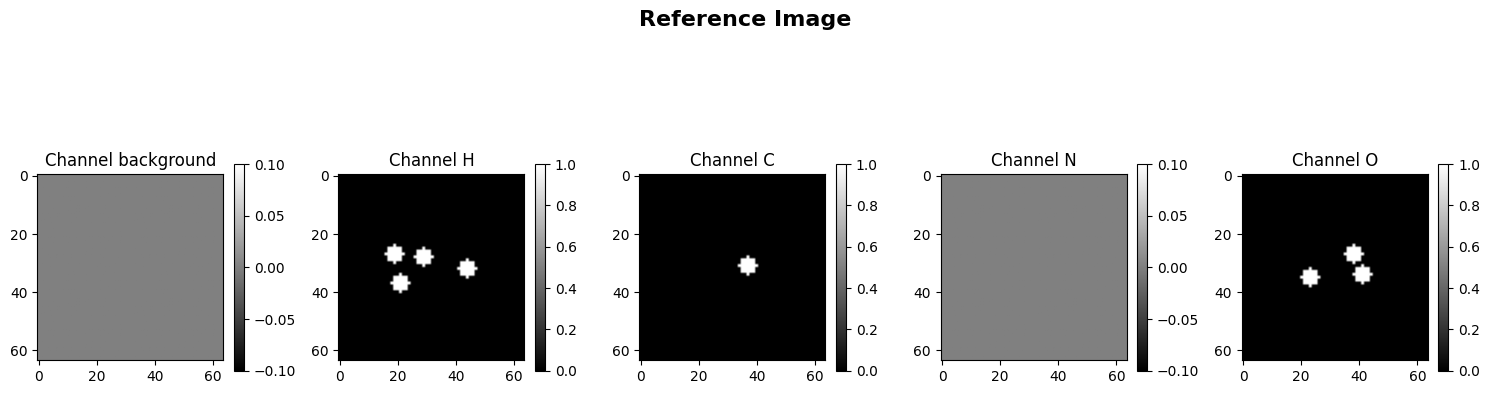

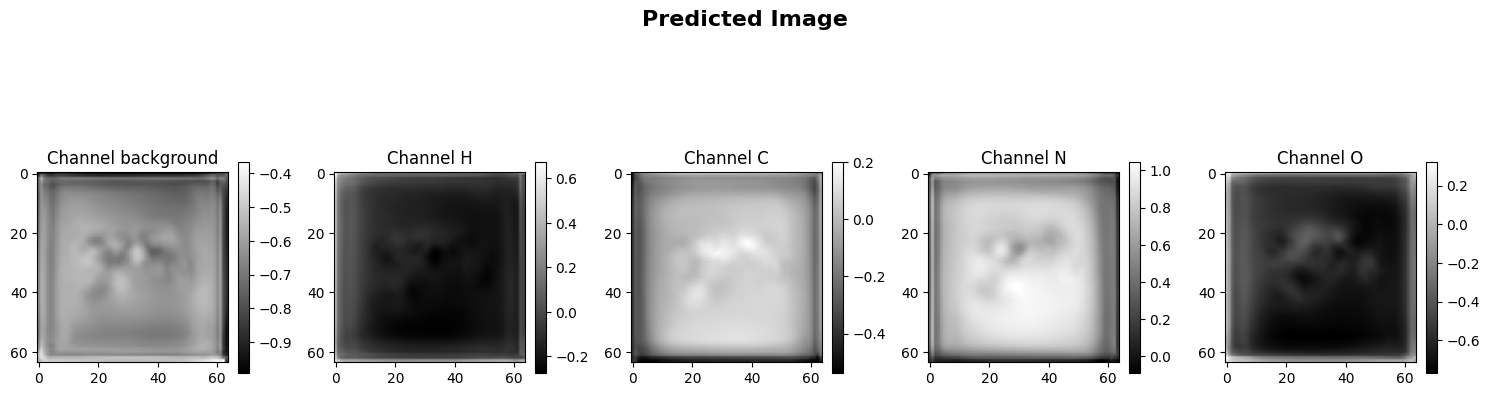

In [17]:

plot_channels(mol_image_new, title_name="Reference Image")
plot_channels(out.detach().numpy().squeeze(), title_name="Predicted Image")

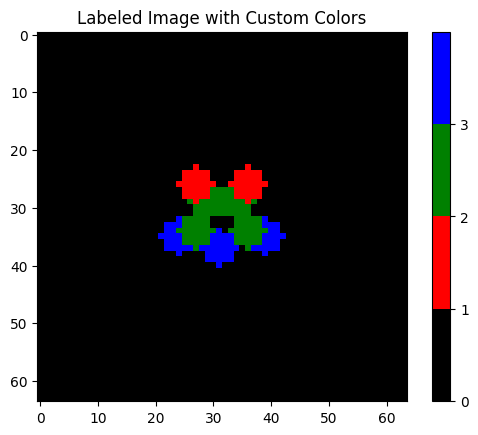

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

t = np.argmax(mol_image_new, axis=0)
# Define custom colors for each label
colors = ["black", "red", "green", "blue"]  # 0 → black, 1 → red, 2 → green, 3 → blue
custom_cmap = ListedColormap(colors)

# Plot with fixed colors
plt.imshow(t, cmap=custom_cmap, interpolation='nearest')
plt.colorbar(ticks=[0, 1, 2, 3])  # Show label values in the color legend
plt.title("Labeled Image with Custom Colors")
plt.show()


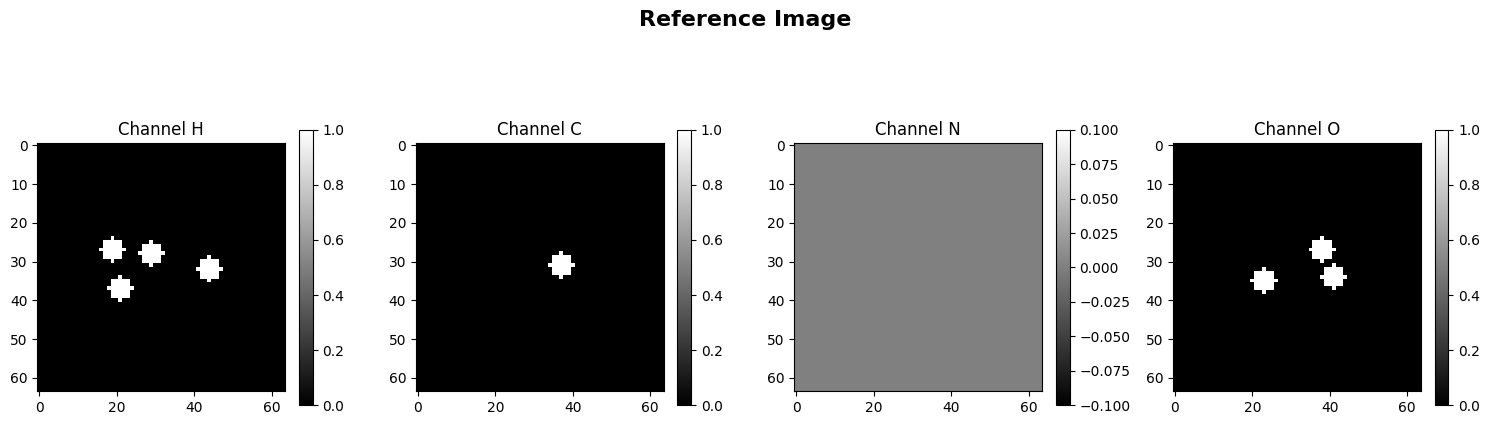

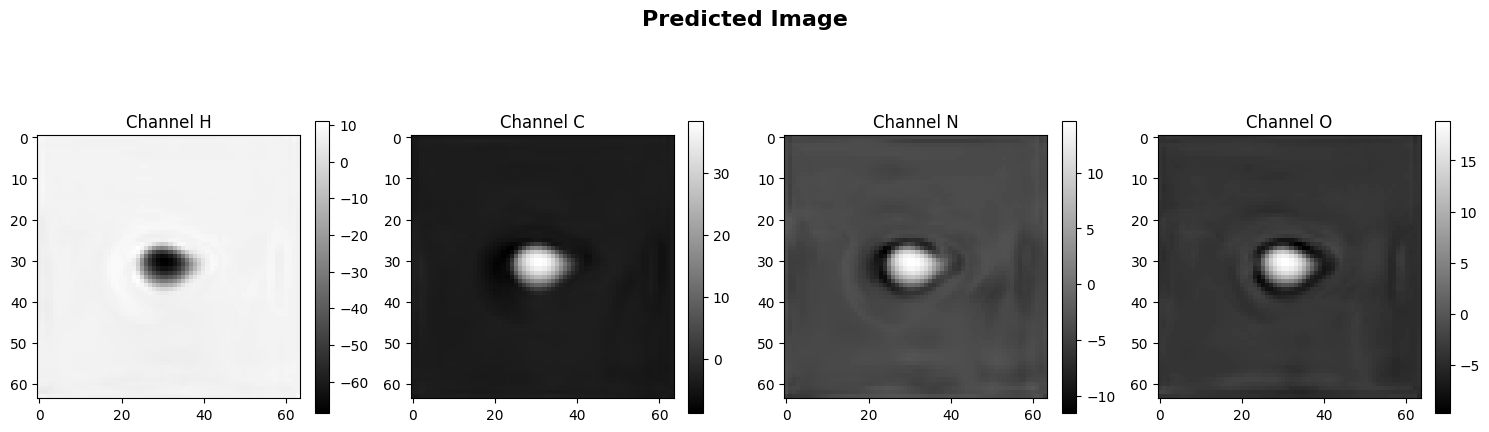

In [ ]:
plot_channels(mol_image, title_name="Reference Image")
plot_channels(out.detach().numpy().squeeze(), title_name="Predicted Image")

In [ ]:
/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images

In [2]:
import sys 
sys.path.append('../')
from src.utils import *

input_dir = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters'
output_dir = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters'

split_data(input_dir, output_dir)

Split 1455 files into 1164 train and 291 val files.
